# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev2 toc-item"><a href="#Imports,-config,-etc" data-toc-modified-id="Imports,-config,-etc-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports, config, etc</a></div>

# Setup

## Imports, config, etc

In [1]:
import os

import pandas as pd
import numpy as np
import model_comparison
import datetime

from scipy import interpolate
from scipy import optimize
import itertools

import statsmodels.api as smapi

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pvlib

%load_ext autoreload
%autoreload 2

/Users/benellis/miniconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    # data[data < 50] = 0 
    return data

snl_data = load_snl()

def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 
              'lat': 35.0549, 'lon': -106.5433}

rtc = make_pvlib_sys(**snl_params)

In [3]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-08')]

In [4]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
pvlib_clear, components, alpha = \
    pvlib.clearsky.detect_clearsky(sample, clear_skies, 
                                   sample.index, 10, return_components=True)

In [5]:
mc = model_comparison.ModelCompareDetect(sample, clear_skies, window=10)

<IPython.core.display.Javascript object>


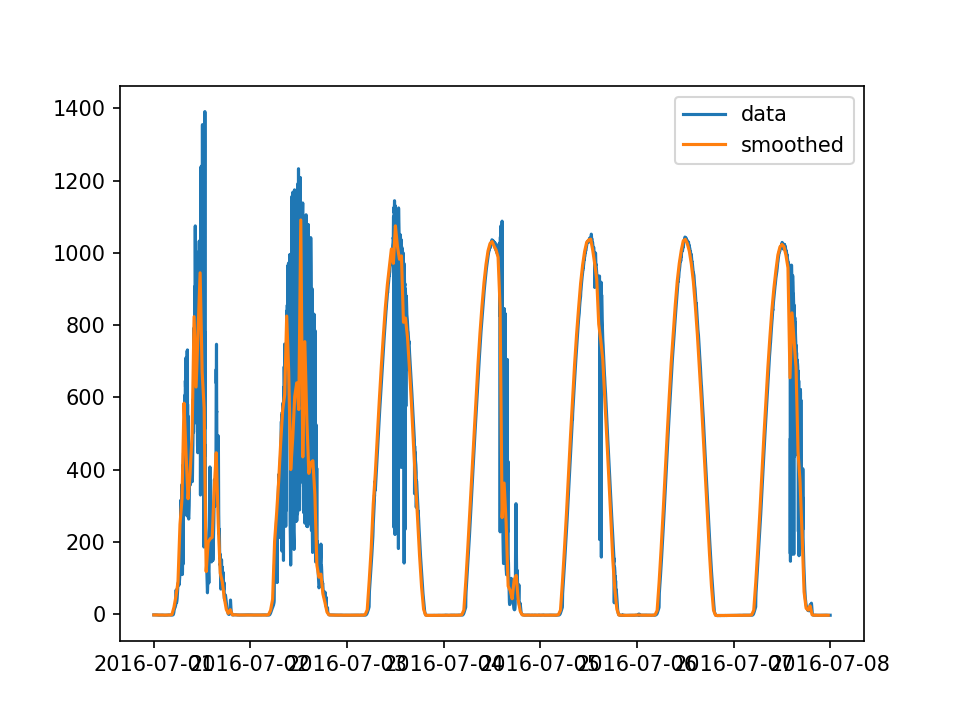

In [6]:
fig, ax = plt.subplots()
# sample2 = mc.data.interpolate(method='quadratic')
# sample2 = mc.data.iloc[::60].interpolate(method='cubic')
sample2 = sample.resample('30T').mean()
# sample2 = mc.data.iloc[::30].interpolate(method='cubic', s=100)
sample2 = sample2.interpolate(method='cubic', s=1000)
ax.plot(sample.index, sample, label='data')
ax.plot(sample2.index, sample2, label='smoothed')
ax.legend()

In [7]:
def spline_error(series, freq):
    series2 = series.resample('10T').mean()
    xs = np.arange(0, len(series2))
    ys = series2.iloc[xs].values
    spline = interpolate.interp1d(xs, ys, kind=3)
    xnew = np.linspace(xs[0], xs[-1], len(series))
    y_pred = spline(xnew)
    fig, ax = plt.subplots()
    ax.plot(xnew, series.values, label='measured')
    ax.plot(xnew, y_pred, label='smoothed')
    ax.legend()
    # new_ser = pd.Series(y_pred)
    # new_ser = y_pred
    # new_ser.index = series.index
    rmse = np.sqrt(np.mean(np.square(series.values - y_pred)))
    print(rmse)
    # return new_ser, spline, rmse

<IPython.core.display.Javascript object>


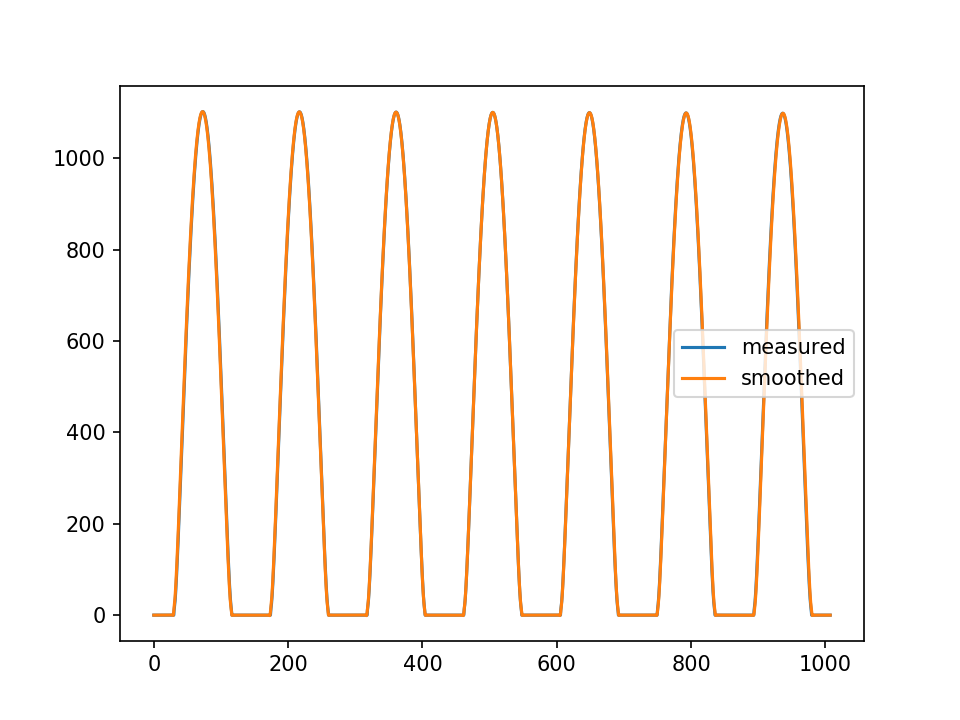

5.5889764147


In [8]:
spline_error(clear_skies, '10')

In [9]:
df = mc.spline_detection()

<IPython.core.display.Javascript object>


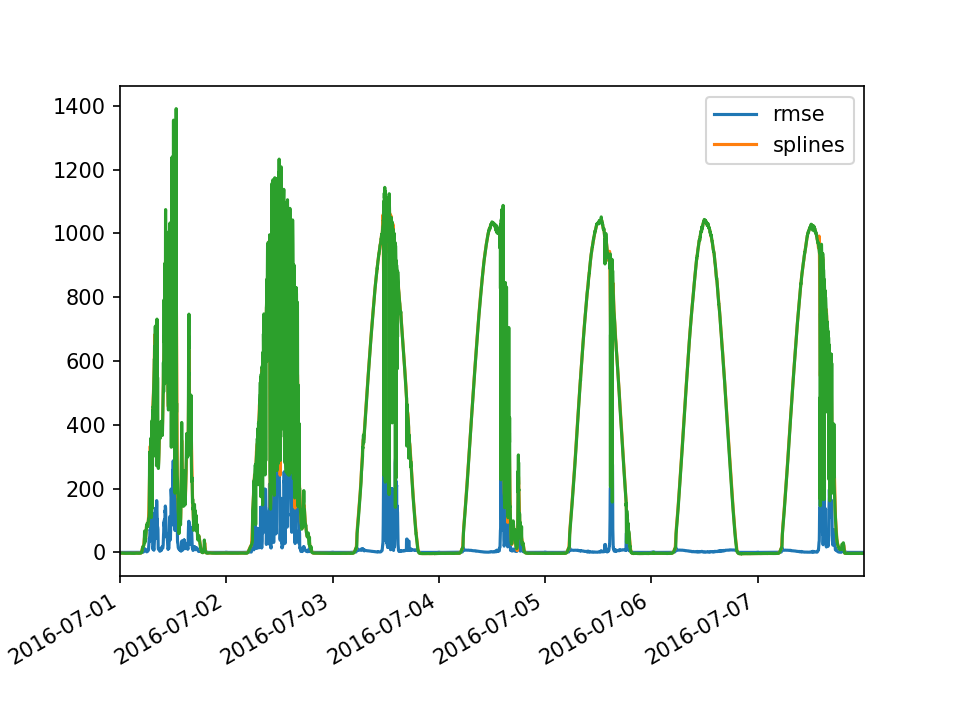

In [10]:
fig, ax = plt.subplots()

df.plot(ax=ax)
sample.plot(ax=ax)

In [ ]:
fig, ax = plt.subplots()

df.plot(ax=ax)
sample.plot(ax=ax)